In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

### Общие функции

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [3]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

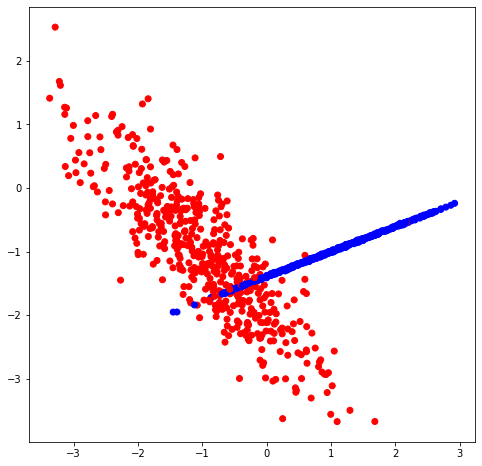

In [4]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [5]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
                
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [7]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

### _Для чистоты эксперимента убрала ограничение на 5 объектов в листе_

In [10]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [11]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
   # print(spacing + 'Индекс', str(node.index))
   # print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
  #  print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
   # print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

###  1) Количество листьев

In [32]:
# Построение дерева с помощью рекурсивной функции
def build_tree_1(data, labels, max_leafs, leafs_count):
    
    print('Come to build_tree')
    print(f'Max leafs: {max_leafs}')
    
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max_leafs==1 or max_leafs<=len(leafs_count)+1:
        leaf = Leaf(data, labels)
        leafs_count.append(leaf)
        print(f'Made leaf: {len(leafs_count)}')
        return leaf

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
   
    print('Go to build true branch')
    # Рекурсивно строим два поддерева
    true_branch = build_tree_1(true_data, true_labels, max_leafs-1, leafs_count)
    
    print(f'After true branch: {len(leafs_count)}')
    
    print('Go to build true branch')
    
    false_branch = build_tree_1(false_data, false_labels, max_leafs, leafs_count)
    
    print(f'After false branch: {len(leafs_count)}')

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [36]:
# Построим дерево по обучающей выборке
my_tree_1 = build_tree_1(train_data, train_labels, max_leafs=7, leafs_count=[])

Come to build_tree
Max leafs: 7
Go to build true branch
Come to build_tree
Max leafs: 6
Go to build true branch
Come to build_tree
Max leafs: 5
Go to build true branch
Come to build_tree
Max leafs: 4
Go to build true branch
Come to build_tree
Max leafs: 3
Made leaf: 1
After true branch: 1
Go to build true branch
Come to build_tree
Max leafs: 4
Go to build true branch
Come to build_tree
Max leafs: 3
Go to build true branch
Come to build_tree
Max leafs: 2
Made leaf: 2
After true branch: 2
Go to build true branch
Come to build_tree
Max leafs: 3
Made leaf: 3
After false branch: 3
After true branch: 3
Go to build true branch
Come to build_tree
Max leafs: 4
Made leaf: 4
After false branch: 4
After false branch: 4
After true branch: 4
Go to build true branch
Come to build_tree
Max leafs: 5
Made leaf: 5
After false branch: 5
After true branch: 5
Go to build true branch
Come to build_tree
Max leafs: 6
Made leaf: 6
After false branch: 6
After true branch: 6
Go to build true branch
Come to build_

In [37]:
print_tree(my_tree_1)

        Прогноз: 1
            Прогноз: 0
            Прогноз: 1
          Прогноз: 0
      Прогноз: 1
    Прогноз: 0
  Прогноз: 1


In [19]:
# Получим ответы для обучающей выборки 
train_answers_1 = predict(train_data, my_tree_1)

In [20]:
# И получим ответы для тестовой выборки
answers_1 = predict(test_data, my_tree_1)

In [21]:
# Точность на обучающей выборке
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
train_accuracy_1

93.28571428571428

In [22]:
# Точность на тестовой выборке
test_accuracy_1 = accuracy_metric(test_labels, answers_1)
test_accuracy_1

87.0

Text(0.5, 1.0, 'Test accuracy=87.00')

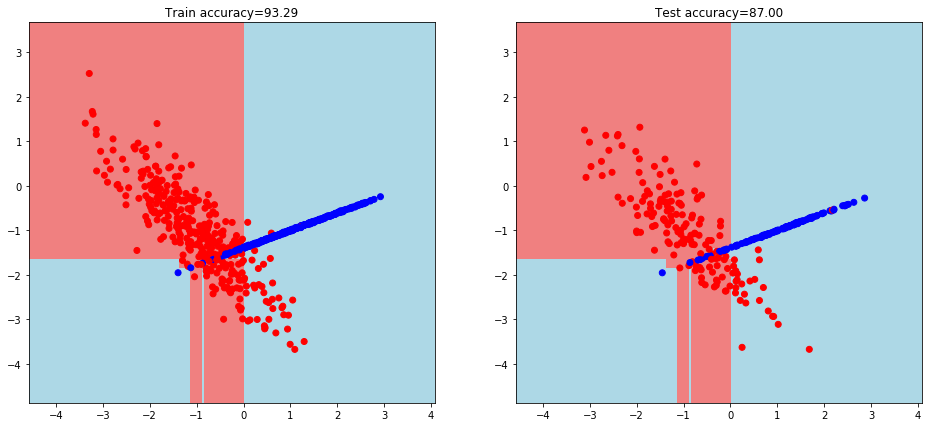

In [23]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_1)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_1:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_1:.2f}')

### 2) Количество узлов

In [24]:
# Построение дерева с помощью рекурсивной функции
def build_tree_2(data, labels, max_nodes, nodes_count):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max_nodes==0 or max_nodes<=len(nodes_count):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    nodes_count.append("")
    true_branch = build_tree_2(true_data, true_labels, max_nodes, nodes_count)
    false_branch = build_tree_2(false_data, false_labels, max_nodes, nodes_count)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [25]:
# Построим дерево по обучающей выборке
my_tree_2 = build_tree_2(train_data, train_labels, max_nodes=15, nodes_count=[])

In [26]:
print_tree(my_tree_2)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -1.3947317874033134
      --> True:
        Прогноз: 1
      --> False:
        Индекс 0
        Порог -0.8728986138474495
        --> True:
          Индекс 0
          Порог -0.9004333947725001
          --> True:
            Индекс 1
            Порог -1.8381873653444054
            --> True:
              Индекс 0
              Порог -1.1235801935520118
              --> True:
                Прогноз: 1
              --> False:
                Прогноз: 0
            --> False:
              Прогноз: 0
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Индекс 1
          Порог -1.5

In [27]:
# Получим ответы для обучающей выборки 
train_answers_2 = predict(train_data, my_tree_2)

In [28]:
# И получим ответы для тестовой выборки
answers_2 = predict(test_data, my_tree_2)

In [29]:
# Точность на обучающей выборке
train_accuracy_2 = accuracy_metric(train_labels, train_answers_2)
train_accuracy_2

93.71428571428572

In [30]:
# Точность на тестовой выборке
test_accuracy_2 = accuracy_metric(test_labels, answers_2)
test_accuracy_2

86.33333333333333

Text(0.5, 1.0, 'Test accuracy=86.33')

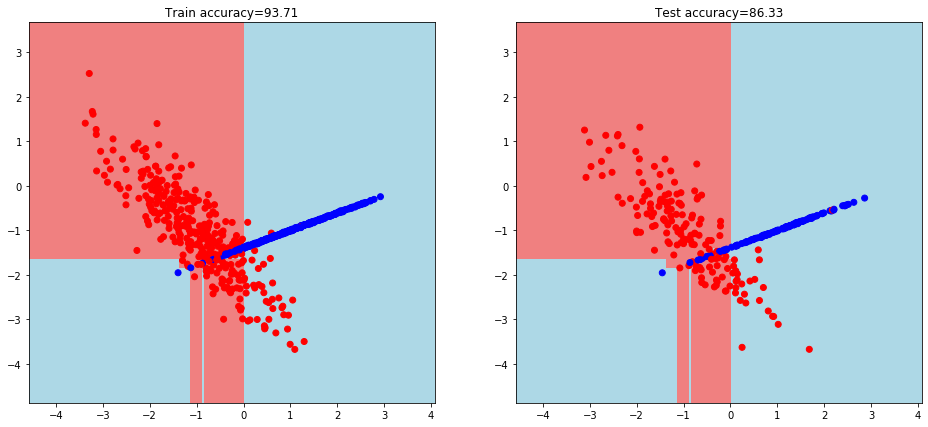

In [31]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_2)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_2:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_2:.2f}')

### 3) Все объекты в листе относятся к одному классу

In [32]:
# Построение дерева с помощью рекурсивной функции
def build_tree_3(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max(labels)==min(labels):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_3(true_data, true_labels)
    false_branch = build_tree_3(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [33]:
# Построим дерево по обучающей выборке
my_tree_3 = build_tree_3(train_data, train_labels)

In [34]:
print_tree(my_tree_3)

Индекс 0
Порог -0.001967524769128759
--> True:
  Индекс 1
  Порог -1.3993975578815423
  --> True:
    Индекс 1
    Порог -1.6646404646216442
    --> True:
      Индекс 0
      Порог -1.3947317874033134
      --> True:
        Прогноз: 1
      --> False:
        Индекс 0
        Порог -0.8728986138474495
        --> True:
          Индекс 0
          Порог -0.9004333947725001
          --> True:
            Индекс 1
            Порог -1.8381873653444054
            --> True:
              Индекс 0
              Порог -1.1235801935520118
              --> True:
                Прогноз: 1
              --> False:
                Прогноз: 0
            --> False:
              Прогноз: 0
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.6882680999463433
      --> True:
        Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.40118216125291906
        --> True:
          Индекс 1
          Порог -1.5

In [35]:
# Получим ответы для обучающей выборки 
train_answers_3 = predict(train_data, my_tree_3)

In [36]:
# И получим ответы для тестовой выборки
answers_3 = predict(test_data, my_tree_3)

In [37]:
# Точность на обучающей выборке
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
train_accuracy_3

100.0

In [38]:
# Точность на тестовой выборке
test_accuracy_3 = accuracy_metric(test_labels, answers_3)
test_accuracy_3

95.33333333333334

Text(0.5, 1.0, 'Test accuracy=95.33')

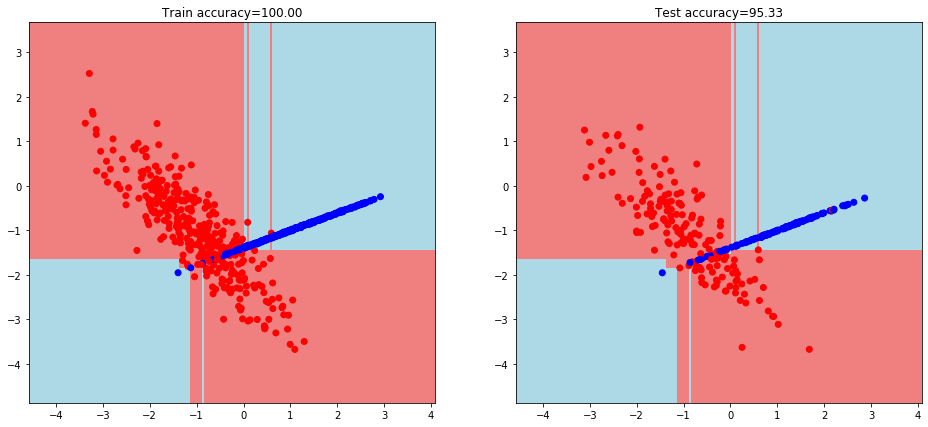

In [39]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_3)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_3:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_3:.2f}')

### 4) Ограничение на улучшение качества

In [40]:
# Построение дерева с помощью рекурсивной функции

def build_tree_4(data, labels, min_quality):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality < min_quality:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_4(true_data, true_labels, min_quality)
    false_branch = build_tree_4(false_data, false_labels, min_quality)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [41]:
# Построим дерево по обучающей выборке
my_tree_4 = build_tree_4(train_data, train_labels, min_quality=0.05)

In [42]:
# Напечатаем ход нашего дерева
print_tree(my_tree_4)

Индекс 0
Порог -0.001967524769128759
--> True:
  Прогноз: 0
--> False:
  Индекс 1
  Порог -1.4518330557811816
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 1


In [43]:
# Получим ответы для обучающей выборки 
train_answers_4 = predict(train_data, my_tree_4)

In [44]:
# И получим ответы для тестовой выборки
answers_4 = predict(test_data, my_tree_4)

In [45]:
# Точность на обучающей выборке
train_accuracy_4 = accuracy_metric(train_labels, train_answers_4)
train_accuracy_4

94.42857142857143

In [46]:
# Точность на тестовой выборке
test_accuracy_4 = accuracy_metric(test_labels, answers_4)
test_accuracy_4

93.66666666666667

Text(0.5, 1.0, 'Test accuracy=93.67')

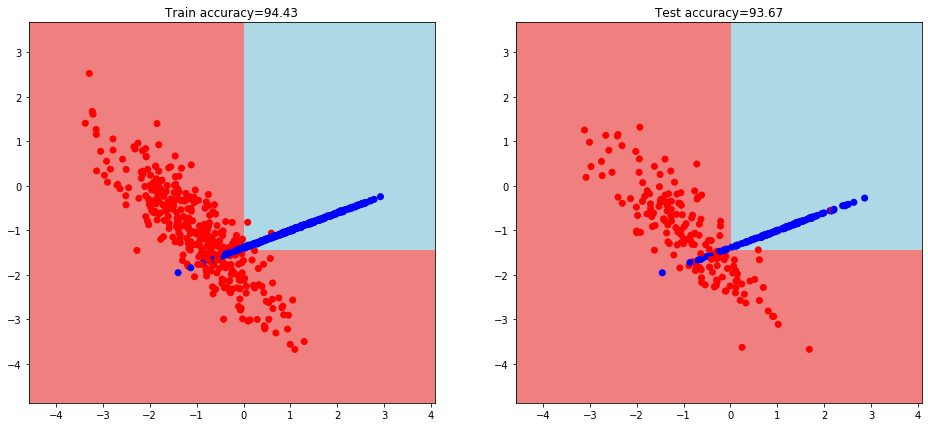

In [47]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_4)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_4:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_4:.2f}')

### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [48]:
# сгенерируем данные
regression_data, regression_targets = datasets.make_regression(n_samples=500, n_features = 2, n_informative = 2,
                                                               random_state=33)

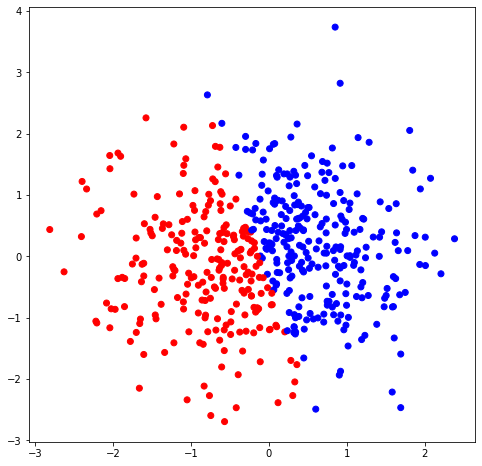

In [49]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], regression_data)), list(map(lambda x: x[1], regression_data)), 
              c=regression_targets, cmap=colors)

In [50]:
# Реализуем класс узла
class regr_Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [51]:
# И класс терминального узла (листа)
class regr_Leaf:
    
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets  # y_true
        self.prediction = self.targets.mean()  # y_pred

In [52]:
# Расчет качества
def regr_quality(left_targets, right_targets, current_var):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_targets.shape[0]) / (left_targets.shape[0] + right_targets.shape[0])
    
    return current_var - p * left_targets.var() - (1 - p) * right_targets.var()

In [53]:
# Разбиение датасета в узле
def regr_split(data, targets, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_targets = targets[left]
    false_targets = targets[right]
        
    return true_data, false_data, true_targets, false_targets

In [54]:
# Нахождение наилучшего разбиения
def regr_find_best_split(data, targets):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_var = targets.var()

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, left_targets, right_targets = regr_split(data, targets, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(left_targets) < min_leaf or len(right_targets) < min_leaf:
                continue
            
            current_quality = regr_quality(left_targets, right_targets, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [55]:
# Построение дерева с помощью рекурсивной функции
def regr_build_tree(data, targets):

    quality, t, index = regr_find_best_split(data, targets)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return regr_Leaf(data, targets)

    left_data, right_data, left_targets, right_targets = regr_split(data, targets, index, t)

    # Рекурсивно строим два поддерева
    left_branch = regr_build_tree(left_data, left_targets)
    right_branch = regr_build_tree(right_data, right_targets)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return regr_Node(index, t, left_branch, right_branch)

In [56]:
# Проход объекта по дереву для его классификации
def regr_classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, regr_Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return regr_classify_object(obj, node.true_branch)
    else:
        return regr_classify_object(obj, node.false_branch)

In [57]:
# Предсказание деревом для всего датасета
def regr_predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = regr_classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [58]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_targets, test_targets = model_selection.train_test_split(regression_data, 
                                                                                     regression_targets, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [59]:
# Построим дерево по обучающей выборке
my_tree_regr = regr_build_tree(train_data, train_targets)

In [60]:
# Напечатаем ход нашего дерева
def regr_print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, regr_Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    regr_print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    regr_print_tree(node.false_branch, spacing + "  ")
    
regr_print_tree(my_tree_regr)

Индекс 0
Порог -0.11489854108045826
--> True:
  Индекс 0
  Порог -1.335254010416089
  --> True:
    Индекс 0
    Порог -1.6462259517089493
    --> True:
      Индекс 0
      Порог -2.2059248271588077
      --> True:
        Прогноз: -94.31308975731837
      --> False:
        Индекс 1
        Порог -0.3604190340492838
        --> True:
          Индекс 0
          Порог -1.9354967619967725
          --> True:
            Прогноз: -87.25566925040435
          --> False:
            Прогноз: -80.17868406786364
        --> False:
          Прогноз: -67.43585438382289
    --> False:
      Прогноз: -56.43920754490122
  --> False:
    Индекс 0
    Порог -0.7315632577178507
    --> True:
      Индекс 1
      Порог 0.3517337529452411
      --> True:
        Индекс 1
        Порог -1.2295975224180797
        --> True:
          Прогноз: -56.21533711889614
        --> False:
          Индекс 0
          Порог -0.9932550253106753
          --> True:
            Индекс 1
            Порог -0.16854

In [61]:
# Получим ответы для обучающей выборки 
regr_train_answers = regr_predict(train_data, my_tree_regr)

In [62]:
# И получим ответы для тестовой выборки
regr_answers = regr_predict(test_data, my_tree_regr)

In [63]:
# Введем функцию подсчета среднеквадратичной ошибки
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err

In [64]:
# Введем функцию подсчета коэффициента детерминации
from sklearn.metrics import r2_score

def calc_r2(y, y_pred):
    return r2_score(y, y_pred)

In [65]:
# Точность на обучающей выборке
train_mse = calc_mse(train_targets, regr_train_answers)
train_mse

18.381854317289537

In [66]:
# Точность на тестовой выборке
test_mse = calc_mse(test_targets, regr_answers)
test_mse

36.651155478484704

In [67]:
# Точность на обучающей выборке
train_r2 = calc_r2(train_targets, regr_train_answers)
train_r2

0.9877356714996609

In [68]:
# Точность на тестовой выборке
test_r2 = calc_r2(test_targets, regr_answers)
test_r2

0.9770651324940283

Text(0.5, 1.0, 'Test R**2=0.98')

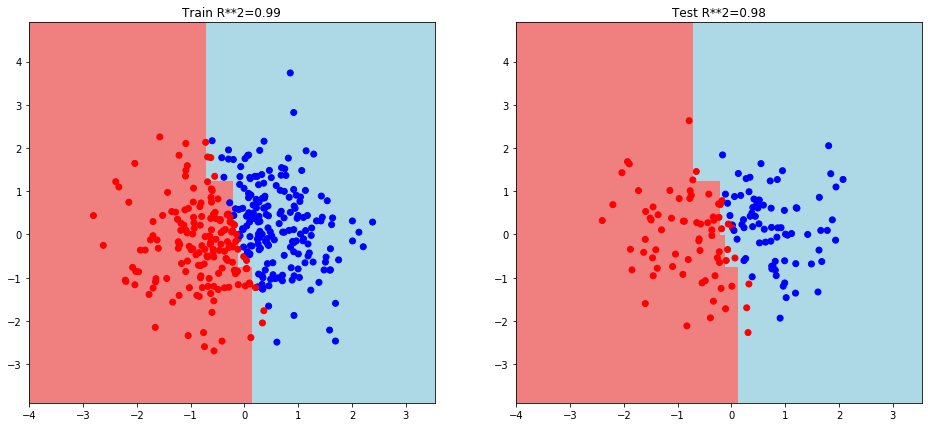

In [69]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(regr_predict(np.c_[xx.ravel(), yy.ravel()], my_tree_regr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_targets, cmap = colors)
#plt.title(f'Train MSE={train_mse:.2f}')
plt.title(f'Train R**2={train_r2:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_targets, cmap = colors)
#plt.title(f'Test MSE={test_mse:.2f}')
plt.title(f'Test R**2={test_r2:.2f}')